In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from openpyxl import load_workbook

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

In [2]:
def Metrics(y, y_pred):
    '''Вычисление метрик качества прогнозов
    '''
    
    mse = round(mean_squared_error(y, y_pred), 4)
    mae = round(mean_absolute_error(y, y_pred), 4)
    mape = round(mean_absolute_percentage_error(y, y_pred), 4)
    R2 = round(r2_score(y, y_pred), 4)
    
    return [mse, mae, mape, R2]


def MetricsDF(model, x_train, x_valid, y_train, y_valid, tableName = 'Errors', testUsed = False, x_test = [], y_test = [], plot = False, savePath = ''):
    '''Формирование таблицы метрик на тренировочной и тестовой выборке
    '''
    
    
    resDf = pd.DataFrame(index=['MSE', 'MAE', 'MAPE', 'R2'], data = 
                             {'Train': Metrics(y_train, model.predict(x_train)),
                             'Valid': Metrics(y_valid, model.predict(x_valid))})
    if testUsed:
        resDf['Test'] = Metrics(y_test, model.predict(x_test))
                        
    resDf.index.name = tableName
    display(resDf)
    
    
    if plot:
        x_valid.sort_index(inplace = True)
        y_valid.sort_index(inplace = True)
        CompareGraph(y_valid.index, y_valid, model.predict(x_valid), 'Истинные значения', 'Прогнозируемые значения', 'Сравнение прогноза с истинными данными. Valid')
        if testUsed:
            x_test.sort_index(inplace = True)
            y_test.sort_index(inplace = True)
            CompareGraph(y_test.index, y_test, model.predict(x_test), 'Истинные значения', 'Прогнозируемые значения', 'Сравнение прогноза с истинными данными. Test')
    
    # Сохранение в файл
    if savePath:
        sheet_name = f'est = {model.n_estimators}, smpl =  {model.min_samples_split}'
        
        # Номер последней строки в файле
        numRow = 0
        wb = load_workbook(savePath)
        if sheet_name in wb.sheetnames:
            numRow = wb[sheet_name].max_row + 2
        
        with pd.ExcelWriter(savePath, engine="openpyxl", mode = 'a', if_sheet_exists='overlay') as writer:
            resDf.to_excel(writer, sheet_name = sheet_name, startrow = numRow)


def PlotGraph(x, y, xlabel, ylabel, title):
    '''Отрисовка графика функции
    '''
    
    plt.figure(figsize = (8, 3))
    plt.plot(x, y)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    plt.grid()
    plt.show()
            
        
def CompareGraph(x, y1, y2, l1, l2, title):
    '''Сравнение графиков двух списков значений
    '''
    
    plt.figure(figsize = (10, 4))
    plt.plot(x, y1, label = l1)
    plt.plot(x, y2, label = l2)

    plt.xlabel('time')
    plt.ylabel('PM 2.5, мкг/м³')
    plt.title(title)
    
    plt.legend()
    plt.grid()
    
    plt.show()
    
    
def splitDataBySeason(df, season):
    '''Разделение данных по сезонам
    '''
    
    # Зима
    if season == 'winters':
        win19 = df[:'2019-03-01 00:00:00']
        win19_20 = df['2019-11-27 00:00:00':'2020-02-27 00:00:00']
        win20_21 = df['2020-11-27 00:00:00':'2021-02-25 00:00:00']
        win21_22 = df['2021-12-15 00:00:00':'2022-02-22 00:00:00']
        win22_23 = df['2022-12-13 00:00:00' : '2023-02-22 00:00:00']

        return pd.concat([win19, win19_20, win20_21, win21_22, win22_23])
    
    # Весна
    if season == 'springs':
        spr19 = pd.concat([df['2019-03-10' : '2019-05-01'], df['2019-11-01' : '2019-11-22']])
        spr20 = pd.concat([df['2020-03-01' : '2020-05-01'], df['2020-11-01' : '2020-11-10']])
        spr21 = pd.concat([df['2021-03-10' : '2021-05-01'], df['2021-11-01' : '2021-11-25']])
        spr22 = pd.concat([df['2022-03-01' : '2022-05-01'], df['2022-11-01' : '2022-11-25']])
        spr23 = df['2023-03-01' : ]

        return pd.concat([spr19, spr20, spr21, spr22, spr23])

    # Лето
    if season == 'summers':
        sum19 = df['2019-05-01' : '2019-07-12']
        sum20 = df['2020-05-01' : '2020-08-01']
        sum21 = df['2021-05-01' : '2021-08-01']
        sum22 = df['2022-05-01' : '2022-08-01']

        return pd.concat([sum19, sum20, sum21, sum22])
    
    # Осень
    if season == 'autumns':
        aut19 = df['2019-08-21' : '2019-10-16']
        aut20 = df['2020-08-17' : '2020-10-30']
        aut21 = df['2021-08-15' : '2021-11-01']
        aut22 = df['2022-08-01' : '2022-10-14']

        return pd.concat([aut19, aut20, aut21, aut22])
    

In [3]:
def RandForestForecast(sensor, fill, district, begin, end, season = '', valid_size = 0.3, test_index = [], params = None, gridSearch = True, paramDependencies = False, plotRes = False, featImp = False,
                       path = '../data/', savePath = ''):
    '''Прогнозирование при помощи случайного леса
    '''
    
    # Данные pm 
    df = pd.read_csv(f"{path}pm25_{sensor}{fill}.csv", sep = ';', index_col = ['Date'], parse_dates = ['Date'], usecols = ['Date', district])
    df.rename(columns = {district : 'pm'}, inplace = True)

    # Исключение выборки прогнозирования
    df.drop(index = [f'2023-02-{i}' for i in range(18, 23)] + [f'2023-03-{i}' for i in range(23, 28)] +
                    [f'2022-07-{i}' for i in range(28, 32)] + [f'2022-08-01'] +
                     [f'2022-10-{i}' for i in range(10, 15)], inplace = True)
        
    
    features = ['Pressure', 'Temperature', 'Wet', 'Wind_dir', 'Wind_speed']
    for feat in features:
        df[feat] = pd.read_csv(f"{path}Features{fill}/{feat}_{sensor}.csv", sep = ';', index_col = ['Date'], parse_dates = ['Date'], usecols = ['Date', district])

        # Проверка на пропуски
        nans = pd.isnull(df[begin : end].values).sum()
             
        if nans > 0:
            print(f'Пропуски в {feat} :', nans)
 
    
    # Добавление инверсий
    inversions = pd.read_csv(f"{path}Inversions.csv", sep = ';', index_col = ['Date'], parse_dates = ['Date'])
        
    df = inversions.join(df)    
    
    
    df.dropna(inplace = True)
    
    
    testUsed = False
    # Формирование тестовой выборки
    if len(test_index):
        testUsed = True
        test_index = list(set(pd.to_datetime(test_index)) & set(df.index))
        x_test = df.loc[test_index].drop(['pm'], axis = 1)
        y_test = df.loc[test_index]['pm']
        df.drop(test_index, inplace = True)
    
    df = df[begin : end]
    
    
    tableName = f'{min(df.index.date)} — {max(df.index.date)}'
    
    
    # Срез для выбранного сезона
    if season:
        df = splitDataBySeason(df, season)
    
    # Разбиение данных
    x = df.drop(['pm'], axis = 1)
    y = df['pm']

    # train : valid выборки 1-valid_size : valid_size
    x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = valid_size, random_state=1)
    
    # Создаем модель
    rf = RandomForestRegressor(random_state = 100)
    
    # Поиск по сетке
    if gridSearch:
        rf = GridSearchCV(estimator = rf, param_grid = params, n_jobs = -1)
    else:
        rf.set_params(**params)
    
    # Обучаем
    rf.fit(x_train, y_train)
    
    # Параметры лучшей модели
    if gridSearch:
        params = rf.best_params_
        rf = rf.best_estimator_
        
    
    tableName += f" N = {params['n_estimators']} features = {params['max_features']}"
    
    if testUsed:
        MetricsDF(rf, x_train, x_valid, y_train, y_valid, tableName, testUsed, x_test, y_test, plotRes, savePath)
    else:
        MetricsDF(rf, x_train, x_valid, y_train, y_valid, tableName, testUsed, plotRes, savePath)
    
    # Определение важности признаков
    if featImp: FeatureImportance(x, rf)
        
        
    # Зависимость качества от параметров
    if paramDependencies:
        # Фиксируем клдичество признаков в узле
        rfDep = RandomForestRegressor(max_features = params['max_features'], random_state = 100)
        
        loss_mse = []
        # Изменение числа деревьев
        n_est_range = range(1, 1002, 100)
        for n_est in n_est_range:
            rfDep.set_params(**{'n_estimators': n_est})
            
            rfDep.fit(x_train, y_train)
            loss_mse.append(mean_squared_error(rfDep.predict(x_valid), y_valid))
        
        
        PlotGraph(n_est_range, loss_mse, 'n_estimators', 'MSE', f"Зависимость MSE от числа деревьев. max_feat = {params['max_features']}")
        
        # Фиксируем число деревьев
        rfDep = RandomForestRegressor(max_features = params['n_estimators'], random_state = 100)
        
        loss_mse = []
        # Изменение количества признаков в узле
        max_feat_range = np.arange(0.1, 1.1, 0.1)
        for max_feat in max_feat_range:
            rfDep.set_params(**{'max_features': max_feat})
            
            rfDep.fit(x_train, y_train)
            loss_mse.append(mean_squared_error(rfDep.predict(x_valid), y_valid))
        
        PlotGraph(max_feat_range, loss_mse, 'max_features', 'MSE', f"Зависимость MSE от количества признаков в узле. N = {params['n_estimators']}")

    
def FeatureImportance(data, model):
    '''Вычисление и отрисовка важности признаков
    '''
    
    # Упорядычиваем наши фичи по значениям весов, от самой полезной к самой бесполезной
    df_importances= sorted(list(zip(data.columns, model.feature_importances_.ravel())), key=lambda tpl: tpl[1], reverse=True)

    # Создаем табличку, в которой будет показан признак и его вес
    df_importances = pd.DataFrame(df_importances, columns=['feature', 'importance']) 

    # Нумируем колонки, чтобы не путать их
    df_importances = df_importances.set_index('feature')

    # Создаем график, чтобы было нагляднее
    df_importances.plot(kind='bar', figsize=(8, 3))

    plt.title('Важность признаков')
    # Рисуем график
    plt.show()

    # Таблица с важностью признаков
    display(df_importances)

In [4]:
sensor = 's'
fill = '_fill'

district = 'Mean'

#savePath = 'Results/Results RF large periods.xlsx'

In [5]:
params = { 
    'n_estimators': np.linspace(1, 1000, 5).round().astype('int'),
    'max_features': np.linspace(0.1, 1, 5)
}
params

{'n_estimators': array([   1,  251,  500,  750, 1000]),
 'max_features': array([0.1  , 0.325, 0.55 , 0.775, 1.   ])}

## Модели, обученные за года

Пропуски в Wind_dir : 1
Пропуски в Wind_speed : 1


,Train,Valid,Test
2020-01-01 — 2023-03-22 N = 1000 features = 0.325,,,
MSE,27.6447,192.4803,382.9879
MAE,3.0932,7.8409,14.4392
MAPE,0.2063,0.5375,0.4875
R2,0.9656,0.7901,0.7121


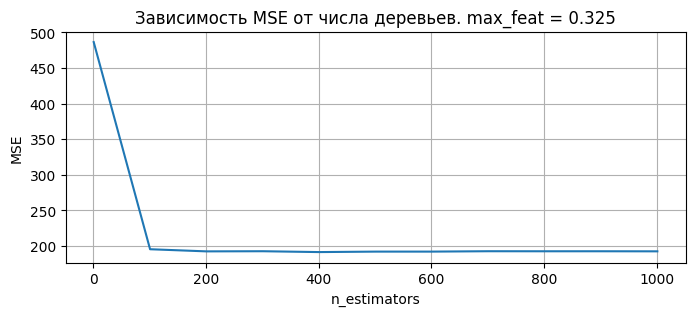

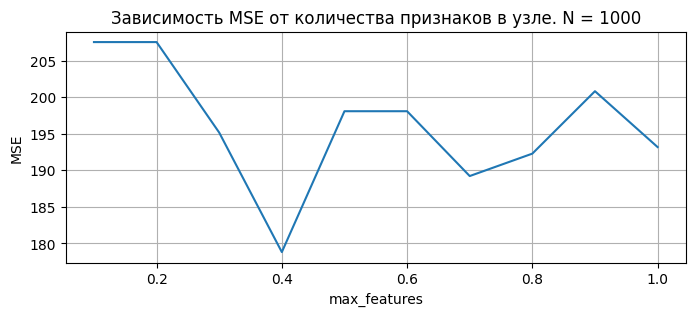

Пропуски в Wind_dir : 1
Пропуски в Wind_speed : 1


,Train,Valid,Test
2020-01-01 — 2023-03-22 N = 750 features = 0.55,,,
MSE,27.9881,244.9022,46.6978
MAE,3.0731,8.6870,5.3595
MAPE,0.2015,0.4806,0.4198
R2,0.9627,0.7953,0.5153


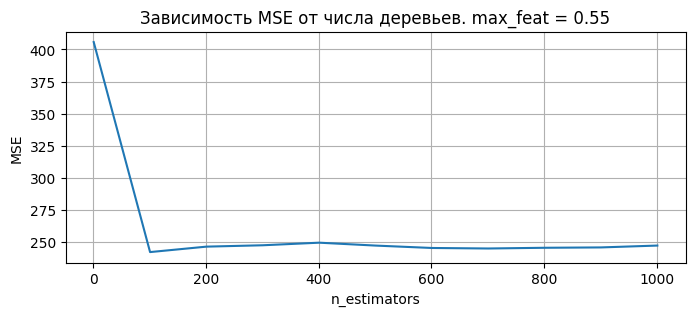

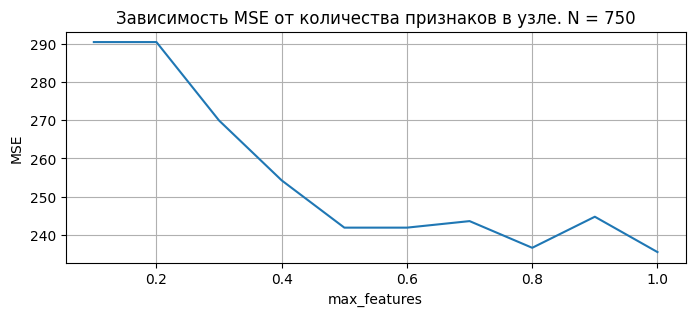

Пропуски в Wind_dir : 1
Пропуски в Wind_speed : 1


,Train,Valid,Test
2020-01-01 — 2023-03-22 N = 1000 features = 0.55,,,
MSE,30.3169,193.2338,42.6540
MAE,3.2031,8.0789,5.0839
MAPE,0.2048,0.5464,0.6891
R2,0.9655,0.7836,0.1246


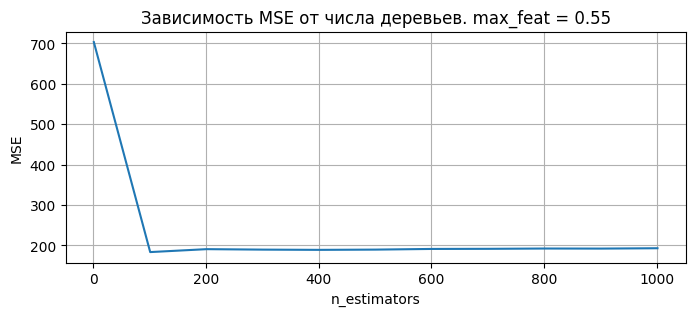

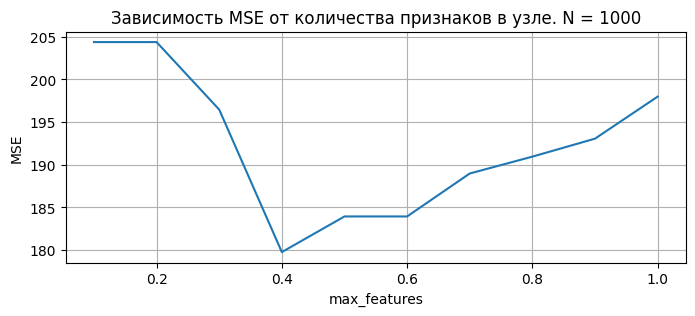

Пропуски в Wind_dir : 1
Пропуски в Wind_speed : 1


,Train,Valid,Test
2020-01-01 — 2023-03-22 N = 500 features = 0.55,,,
MSE,29.4894,194.3473,31.8114
MAE,3.1003,8.3438,4.4389
MAPE,0.1982,0.5574,0.6498
R2,0.9655,0.7950,0.2861


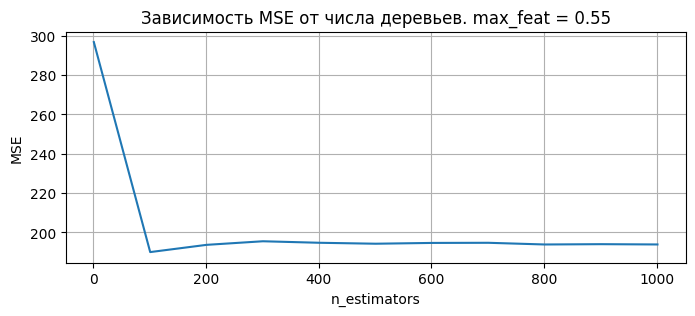

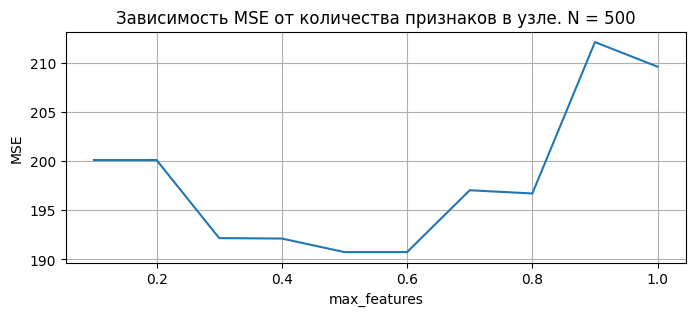

In [6]:
# Срез данных от begin до end
begin, end = '2020-01-01', '2023-04-06'

for season in ['winters', 'springs', 'summers', 'autumns']:
    test_index = pd.read_csv(f"../data/test_index.csv", sep = ';', dayfirst=True, parse_dates = [season])[season].values
    RandForestForecast(sensor, fill, district, begin, end, season = '', test_index = test_index, params = params, gridSearch = True, paramDependencies = True, plotRes = False, featImp = False)

## Сезонные модели

Пропуски в Wind_dir : 1
Пропуски в Wind_speed : 1


,Train,Valid,Test
2019-01-01 — 2023-03-22 N = 251 features = 0.775,,,
MSE,71.5611,805.9224,469.2674
MAE,5.7582,17.9763,15.8172
MAPE,0.1760,0.3964,0.4684
R2,0.9647,0.6048,0.6473


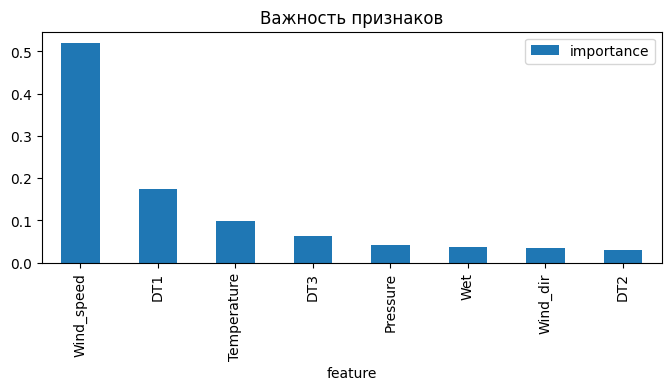

,importance
feature,
Wind_speed,0.521027
DT1,0.173463
Temperature,0.098950
DT3,0.063485
Pressure,0.042240
Wet,0.036514
Wind_dir,0.033508
DT2,0.030813


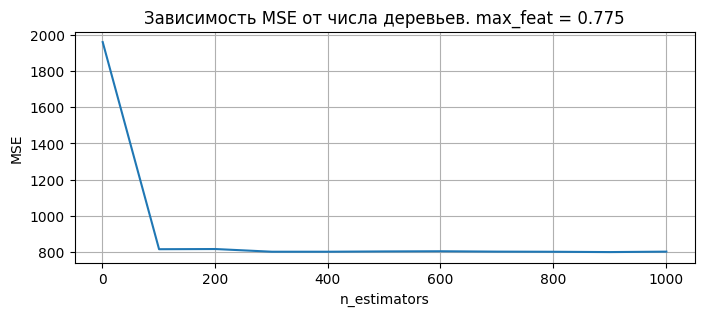

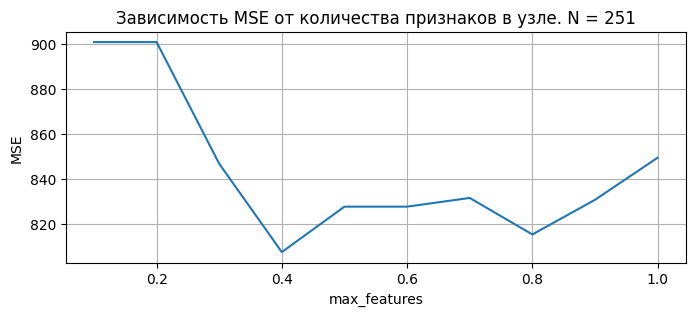

Пропуски в Wind_dir : 1
Пропуски в Wind_speed : 1


,Train,Valid,Test
2019-01-01 — 2023-03-22 N = 750 features = 0.55,,,
MSE,6.4544,40.0778,43.4523
MAE,1.8871,4.8270,4.6855
MAPE,0.1596,0.3523,0.3796
R2,0.9486,0.6333,0.5490


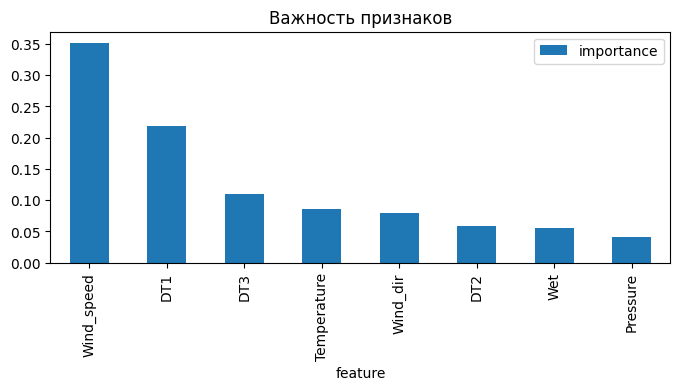

,importance
feature,
Wind_speed,0.352254
DT1,0.218754
DT3,0.110146
Temperature,0.085355
Wind_dir,0.079609
DT2,0.058246
Wet,0.054624
Pressure,0.041012


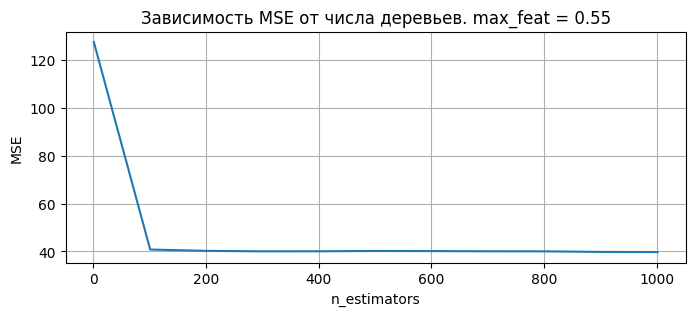

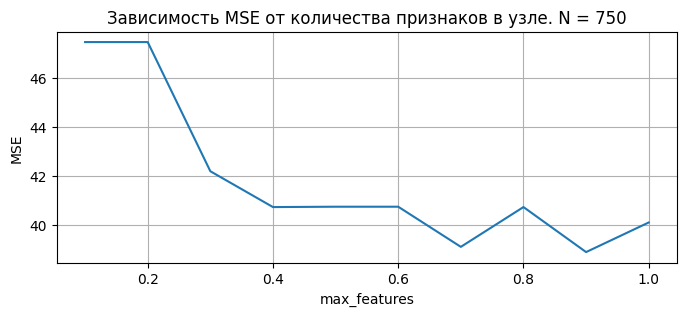

Пропуски в Wind_dir : 1
Пропуски в Wind_speed : 1


,Train,Valid,Test
2019-01-01 — 2023-03-22 N = 251 features = 0.1,,,
MSE,4.3496,17.6139,25.9594
MAE,1.3293,3.4034,3.9827
MAPE,0.1744,0.5473,0.5100
R2,0.8916,0.2094,0.4672


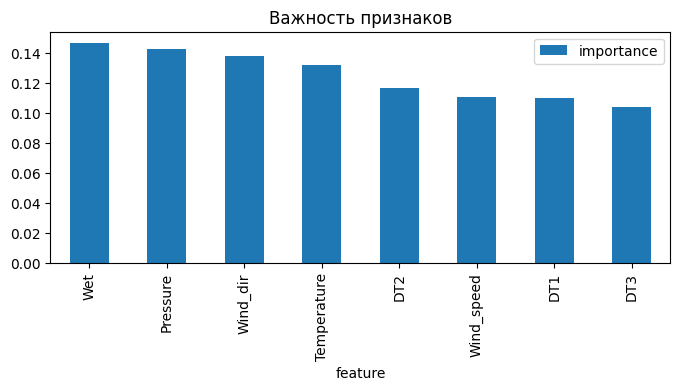

,importance
feature,
Wet,0.146953
Pressure,0.142587
Wind_dir,0.137824
Temperature,0.131768
DT2,0.116607
Wind_speed,0.110839
DT1,0.109809
DT3,0.103613


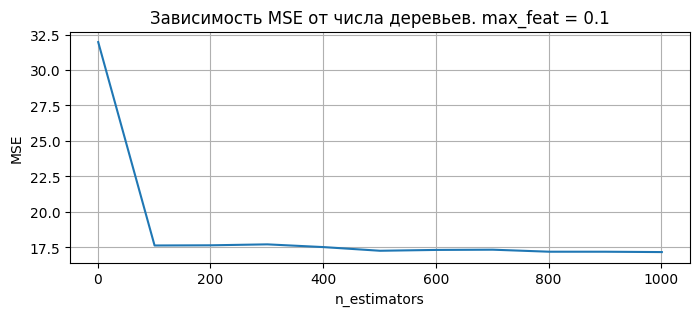

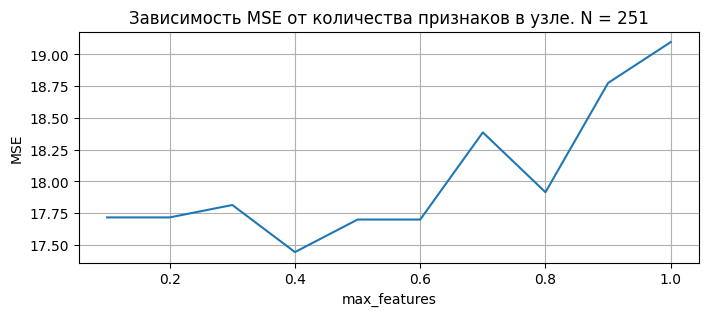

Пропуски в Wind_dir : 1
Пропуски в Wind_speed : 1


,Train,Valid,Test
2019-01-01 — 2023-03-22 N = 1000 features = 0.775,,,
MSE,3.2351,32.0936,30.2402
MAE,1.3401,3.7858,4.2676
MAPE,0.1727,0.4234,0.6449
R2,0.9514,0.3010,0.3214


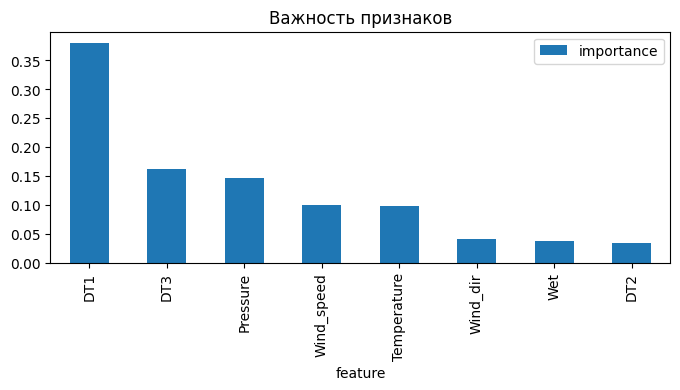

,importance
feature,
DT1,0.380933
DT3,0.161878
Pressure,0.146931
Wind_speed,0.099516
Temperature,0.098414
Wind_dir,0.040816
Wet,0.038151
DT2,0.033361


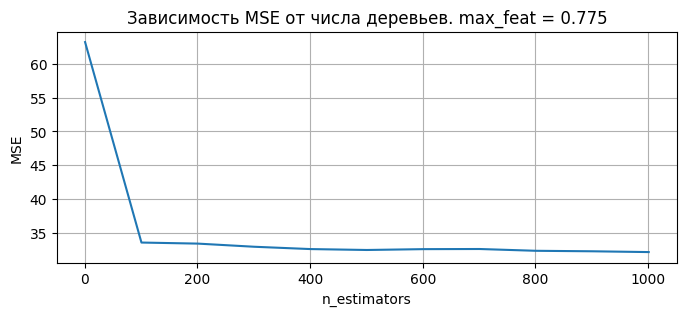

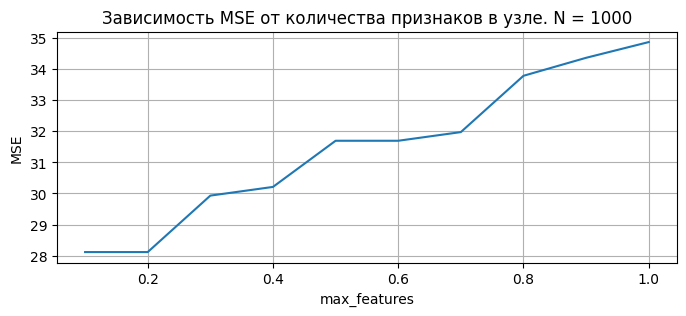

In [7]:
begin, end = '2019-01-01', '2023-04-06'

for season in ['winters', 'springs', 'summers', 'autumns']:
    test_index = pd.read_csv(f"../data/test_index.csv", sep = ';', dayfirst=True, parse_dates = [season])[season].values
    RandForestForecast(sensor, fill, district, begin, end, season = season, test_index = test_index, params = params, gridSearch = True, paramDependencies = True, plotRes = False, featImp = True)